In [1]:
import typing as tp
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = Path("../data/raw")

sns.set(style="whitegrid")

In [2]:
def load_image_paths(root_dir: Path) -> pd.DataFrame:
    """
    Recursively collect all image file paths and map them to their class label.
    """
    records: tp.List[tp.Dict[str, tp.Any]] = []

    for split_dir in sorted(root_dir.iterdir()):
        if not split_dir.is_dir():
            continue
        split_name = split_dir.name  # e.g., train, valid, test

        for class_dir in sorted(split_dir.iterdir()):
            if not class_dir.is_dir():
                continue
            class_name = class_dir.name
            images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.JPG")) + list(class_dir.glob("*.png"))
            for img_path in images:
                records.append({"split": split_name, "class": class_name, "path": img_path})

    df = pd.DataFrame(records)
    return df


def display_image(img_path: Path, title: tp.Optional[str] = None, figsize: tp.Tuple[int, int] = (5, 5)) -> None:
    """
    Display a single image with optional title.
    """
    try:
        with Image.open(img_path) as img:
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.axis("off")
            if title is None:
                title = img_path.parent.name
            plt.title(title)
            plt.show()
    except Exception as e:
        print(f"Failed to open {img_path}: {e}")

In [ ]:
df = load_image_paths(root_dir)
train_samples = df[df["split"] == "train"]

### Let's research some popular augmentation functions

To do that, we'll install the `albumentations` library.

In [ ]:
!pip install albumentations

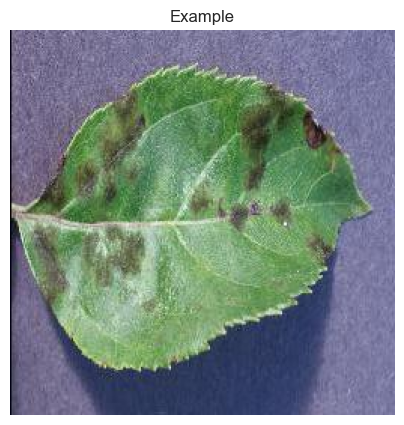

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def apply_augmentation(img_path: Path, transform: A.BasicTransform, title: str):
    with Image.open(img_path) as img:
        img_np = np.array(img)

    augmented = transform(image=img_np)["image"]

    plt.figure(figsize=(6, 6))
    plt.imshow(augmented)
    plt.title(title)
    plt.axis("off")
    plt.show()


sample_img = train_samples['path'].iloc[1]
display_image(sample_img, "Example")

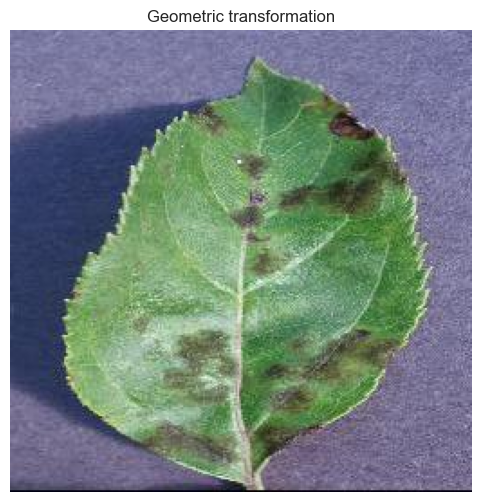

In [22]:
# Geometric Transformations
geom_transform = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.RandomRotate90(p=1.0),
])

apply_augmentation(sample_img, geom_transform, "Geometric transformation")

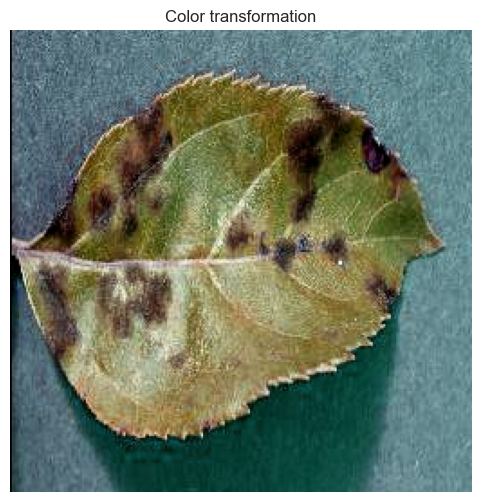

In [26]:
# Color transformation
color_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.5, p=1.0),
    A.HueSaturationValue(hue_shift_limit=35, sat_shift_limit=10, val_shift_limit=15, p=1.0),
])

apply_augmentation(sample_img, color_transform, "Color transformation")

/var/folders/8r/zrjm4hxd2752djqdmtnnvk700000gn/T/ipykernel_93546/3976046321.py:4: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 10), p=0.6),


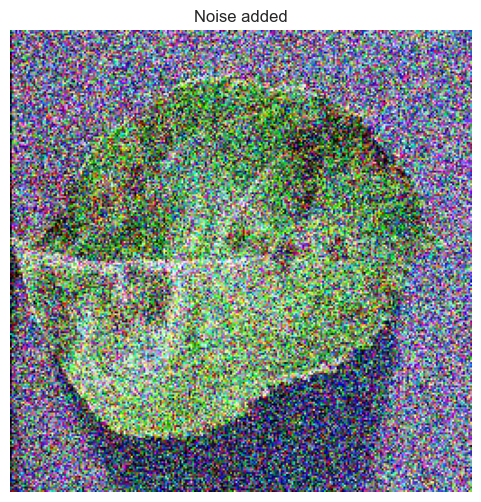

In [39]:
# Adding noise to the image
texture_transform = A.Compose([
    A.GaussianBlur(blur_limit=(2, 4), p=0.5),
    A.GaussNoise(var_limit=(10, 10), p=0.6),
])

apply_augmentation(sample_img, texture_transform, "Noise added")


/var/folders/8r/zrjm4hxd2752djqdmtnnvk700000gn/T/ipykernel_93546/3143344696.py:3: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=40, max_width=50, fill_value=0, p=1.0)


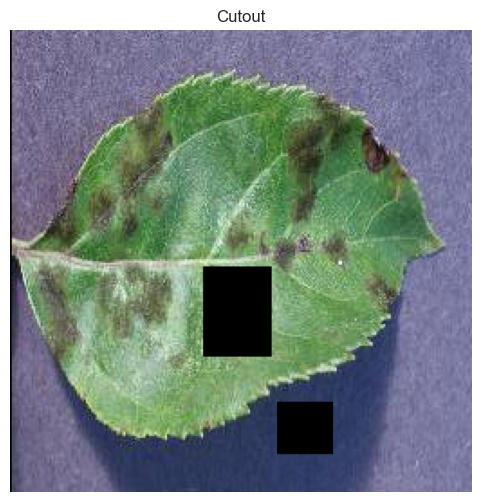

In [44]:
# Cutout the image patch
cutout_transform = A.Compose([
    A.CoarseDropout(max_holes=8, max_height=40, max_width=50, fill_value=0, p=1.0)
])

apply_augmentation(sample_img, cutout_transform, "Cutout")

/var/folders/8r/zrjm4hxd2752djqdmtnnvk700000gn/T/ipykernel_93546/682411655.py:2: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=300, sigma=30, alpha_affine=100, p=1),


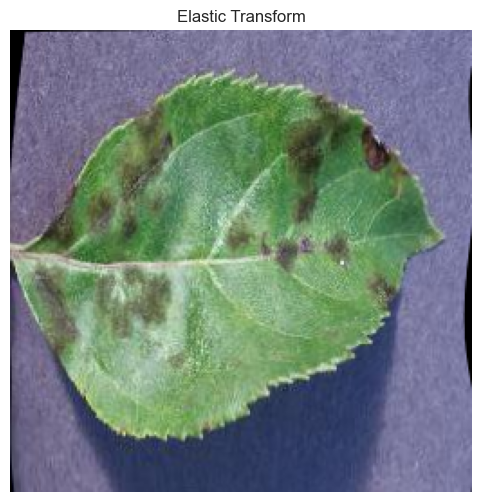

In [62]:
elastic_transform = A.Compose([
    A.ElasticTransform(alpha=300, sigma=30, alpha_affine=100, p=1),
])

apply_augmentation(sample_img, elastic_transform, "Elastic Transform")

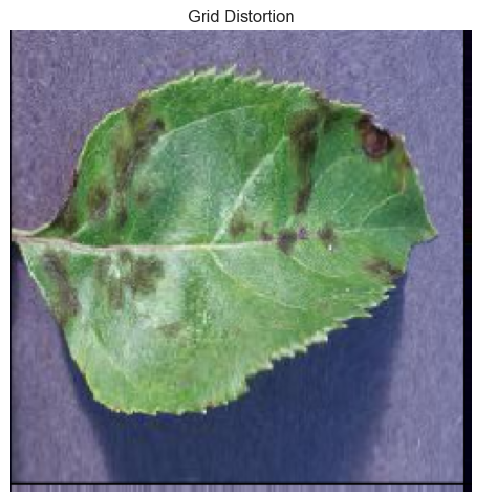

In [66]:
distort_transform = A.Compose([
    A.GridDistortion(num_steps=20, distort_limit=0.4, p=1.0),
])

apply_augmentation(sample_img, distort_transform, "Grid Distortion")

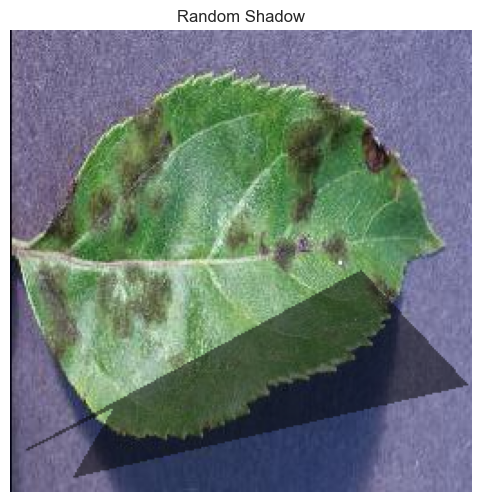

In [67]:
shadow_transform = A.Compose([
    A.RandomShadow(p=1.0),
])

apply_augmentation(sample_img, shadow_transform, "Random Shadow")

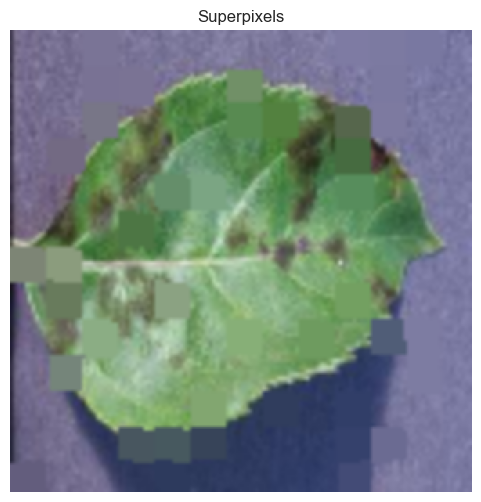

In [68]:
superpixel_transform = A.Compose([
    A.Superpixels(p_replace=0.3, n_segments=200, p=1.0),
])

apply_augmentation(sample_img, superpixel_transform, "Superpixels")